In [1]:
# coding: utf-8
# pylint: disable=invalid-name, no-member

%matplotlib inline
from __future__ import print_function
import argparse
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon as g
from mxnet.gluon import nn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ctx = mx.gpu(0)
lr = 0.01
epoches = 100
margin = 0.2
seed = 0
np.random.seed(seed)
mx.random.seed(seed)

In [3]:
### Data Part

class MNIST(g.data.vision.MNIST):

    def __init__(self, root, train=True, transform=None, num_per_batch=10):
        super(MNIST, self).__init__(root, train, transform)
        self._data = self._data.asnumpy()
        self.num_per_batch = num_per_batch
        self._label_lst = [[] for _ in range(10)]
        for idx, label in enumerate(self._label):
            self._label_lst[label].append(idx)
        self._label_lst = [np.array(_) for _ in self._label_lst]
        self._label_idx = [0 for _ in range(10)]

    def __getitem__(self, idx):
        data = np.zeros((10*self.num_per_batch, 1, 28, 28), dtype=np.float32)
        label = np.zeros(10*self.num_per_batch, dtype=np.float32)
        for i in range(10):
            label_idx = self._label_idx[i]
            label_lst = self._label_lst[i]
            if label_idx + self.num_per_batch <= len(label_lst):
                b, e = label_idx, label_idx + self.num_per_batch
                idxs = label_lst[range(b, e)]
            else:
                b1, e1 = label_idx, len(label_lst)
                b2, e2 = 0, self.num_per_batch - (e1 - b1)
                idxs = label_lst[range(b1, e1) + range(b2, e2)]
            data[i*self.num_per_batch: (i+1)*self.num_per_batch], _ = self._transform(self._data[idxs], None)
            label[i*self.num_per_batch: (i+1)*self.num_per_batch] = i
            label_idx += self.num_per_batch
            if label_idx >= len(label_lst):
                label_idx = 0
                np.random.shuffle(label_lst)
            self._label_idx[i] = label_idx
            self._label_lst[i] = label_lst
        return data, label

    def __len__(self):
        l = super(MNIST, self).__len__()
        l /= 10 * self.num_per_batch
        return l


def transform(data, label):
    if len(data.shape) == 3:
        data = data.reshape((1, 28, 28)).astype(np.float32)
        data = (data - 128) / 128
    else:
        num = data.shape[0]
        data = data.reshape((num, 1, 28, 28)).astype(np.float32)
        data = (data - 128) / 128
    return data, label


train_loader = g.data.DataLoader(MNIST(root='./data', train=True, transform=transform), batch_size=1, shuffle=False, last_batch='discard')
test_loader = g.data.DataLoader(MNIST(root='./data', train=False, transform=transform), batch_size=1, shuffle=False)

In [4]:
### Model Part

class Net(g.HybridBlock):

    def __init__(self):
        super(Net, self).__init__()
        with self.name_scope():
            self.conv1_1 = nn.Conv2D(20, 3, 1, 1)
            self.bn1_1 = nn.BatchNorm()
            self.conv1_2 = nn.Conv2D(20, 3, 1, 1)
            self.bn1_2 = nn.BatchNorm()
            self.pool1 = nn.MaxPool2D(2, 2)
            self.conv2_1 = nn.Conv2D(40, 3, 1, 1)
            self.bn2_1 = nn.BatchNorm()
            self.conv2_2 = nn.Conv2D(40, 3, 1, 1)
            self.bn2_2 = nn.BatchNorm()
            self.pool2 = nn.MaxPool2D(2, 2)
            self.fc3_1 = nn.Dense(64)
            self.fc3_2 = nn.Dense(2)
            self.bn3 = nn.BatchNorm()

    def hybrid_forward(self, F, x):
        x = self.bn1_1(F.relu(self.conv1_1(x)))
        x = self.bn1_2(F.relu(self.conv1_2(x)))
        x = self.pool1(x)
        x = self.bn2_1(F.relu(self.conv2_1(x)))
        x = self.bn2_2(F.relu(self.conv2_2(x)))
        x = self.pool2(x)
        x = self.fc3_2(F.relu(self.fc3_1(x)))
        x = self.bn3(x)
        return x


net = Net()
net.initialize(mx.init.Normal(), ctx=ctx)
criterion = g.loss.TripletLoss(margin=margin)
trainer = g.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9, 'wd': 5e-4})

In [5]:
### Plot Part

def plot_mnist_test(epoch, train=False):
    net = Net()
    net.load_params('./tmp/net-%04d.params'%epoch, ctx=ctx)
    test_loader = g.data.DataLoader(g.data.vision.MNIST(root='./data', train=train, transform=transform), batch_size=32, shuffle=False)
    label_embedding = [[] for _ in range(10)]
    for i, (data, label) in enumerate(test_loader):
        data = data.as_in_context(ctx)
        embedding = net(data)
        for idx, label_idx in enumerate(label):
            label_embedding[label_idx.asscalar()].append(embedding[idx].asnumpy())
    label_embedding = [np.array(_) for _ in label_embedding]
    plt.figure()
    palette = np.array(sns.color_palette('hls', 10))
    for i in range(10):
        plt.scatter(label_embedding[i][:, 0], label_embedding[i][:, 1], c=palette[i], s=10)
    plt.show()

[epoch 1] lr 0.010000
[epoch 1][iter 100] loss: 0.265702
[epoch 1][iter 200] loss: 0.191940
[epoch 1][iter 300] loss: 0.191644
[epoch 1][iter 400] loss: 0.190329
[epoch 1][iter 500] loss: 0.194706
[epoch 1][iter 600] loss: 0.196477
[epoch 1][test] loss: 0.020895
[epoch 2] lr 0.009800
[epoch 2][iter 100] loss: 0.201660
[epoch 2][iter 200] loss: 0.195157
[epoch 2][iter 300] loss: 0.199339
[epoch 2][iter 400] loss: 0.198984
[epoch 2][iter 500] loss: 0.197664
[epoch 2][iter 600] loss: 0.203569
[epoch 2][test] loss: 0.008547
[epoch 3] lr 0.009604
[epoch 3][iter 100] loss: 0.200979
[epoch 3][iter 200] loss: 0.193679
[epoch 3][iter 300] loss: 0.209023
[epoch 3][iter 400] loss: 0.205659
[epoch 3][iter 500] loss: 0.189721
[epoch 3][iter 600] loss: 0.198513
[epoch 3][test] loss: 0.008432
[epoch 4] lr 0.009412
[epoch 4][iter 100] loss: 0.201829
[epoch 4][iter 200] loss: 0.204569
[epoch 4][iter 300] loss: 0.197179
[epoch 4][iter 400] loss: 0.200233
[epoch 4][iter 500] loss: 0.203301
[epoch 4][iter

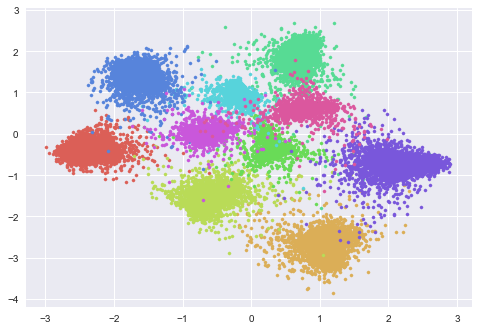

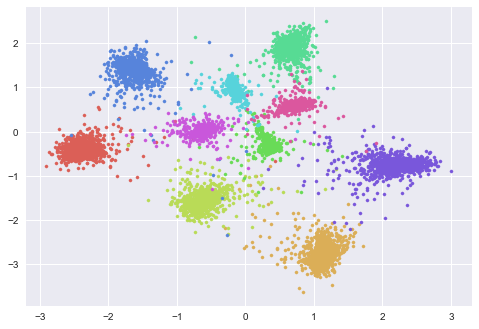

[epoch 11] lr 0.008171
[epoch 11][iter 10] loss: 0.191087
[epoch 11][iter 110] loss: 0.212702
[epoch 11][iter 212] loss: 0.187847
[epoch 11][iter 313] loss: 0.215837
[epoch 11][iter 413] loss: 0.224863
[epoch 11][iter 515] loss: 0.218933
[epoch 11][test] loss: 0.007401
[epoch 12] lr 0.008007
[epoch 12][iter 15] loss: 0.177996
[epoch 12][iter 115] loss: 0.206603
[epoch 12][iter 217] loss: 0.194826
[epoch 12][iter 319] loss: 0.208672
[epoch 12][iter 420] loss: 0.192598
[epoch 12][iter 521] loss: 0.209970
[epoch 12][test] loss: 0.006990
[epoch 13] lr 0.007847
[epoch 13][iter 22] loss: 0.198272
[epoch 13][iter 122] loss: 0.211949
[epoch 13][iter 224] loss: 0.198988
[epoch 13][iter 327] loss: 0.194042
[epoch 13][iter 429] loss: 0.212259
[epoch 13][iter 533] loss: 0.199497
[epoch 13][test] loss: 0.005869
[epoch 14] lr 0.007690
[epoch 14][iter 33] loss: 0.206679
[epoch 14][iter 133] loss: 0.181180
[epoch 14][iter 233] loss: 0.248448
[epoch 14][iter 335] loss: 0.191973
[epoch 14][iter 436] los

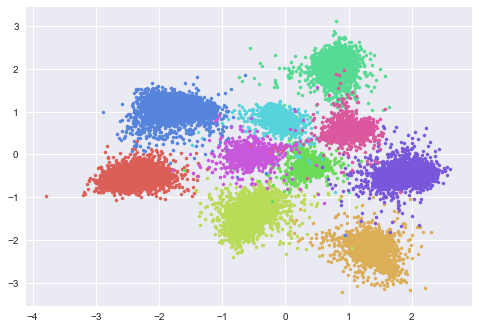

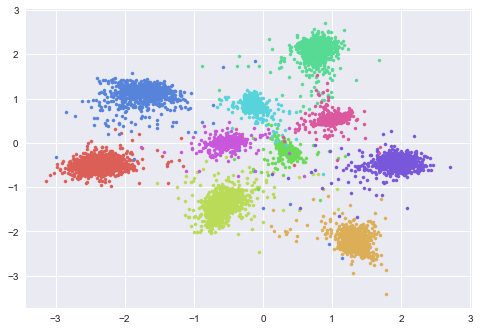

[epoch 21] lr 0.006676
[epoch 21][iter 69] loss: 0.205344
[epoch 21][iter 179] loss: 0.202629
[epoch 21][iter 284] loss: 0.215831
[epoch 21][iter 388] loss: 0.194821
[epoch 21][iter 491] loss: 0.214983
[epoch 21][iter 596] loss: 0.187873
[epoch 21][test] loss: 0.006443
[epoch 22] lr 0.006543
[epoch 22][iter 99] loss: 0.188263
[epoch 22][iter 202] loss: 0.222393
[epoch 22][iter 310] loss: 0.190857
[epoch 22][iter 419] loss: 0.212839
[epoch 22][iter 530] loss: 0.204727
[epoch 22][test] loss: 0.009406
[epoch 23] lr 0.006412
[epoch 23][iter 39] loss: 0.236504
[epoch 23][iter 147] loss: 0.191501
[epoch 23][iter 252] loss: 0.198841
[epoch 23][iter 356] loss: 0.188393
[epoch 23][iter 459] loss: 0.216152
[epoch 23][iter 565] loss: 0.223777
[epoch 23][test] loss: 0.006893
[epoch 24] lr 0.006283
[epoch 24][iter 71] loss: 0.176987
[epoch 24][iter 177] loss: 0.228079
[epoch 24][iter 294] loss: 0.199138
[epoch 24][iter 410] loss: 0.198781
[epoch 24][iter 522] loss: 0.201311
[epoch 24][test] loss: 0

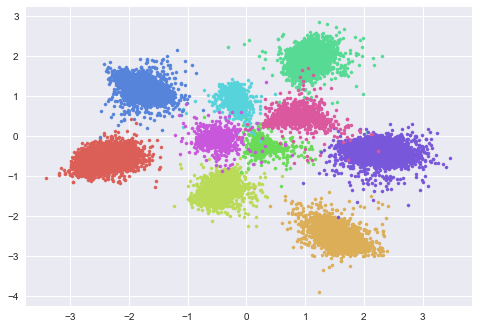

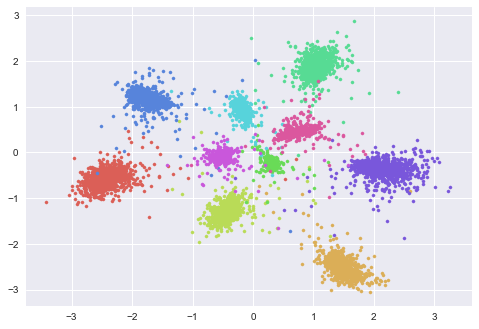

[epoch 31] lr 0.005455
[epoch 31][iter 13] loss: 0.185973
[epoch 31][iter 132] loss: 0.204957
[epoch 31][iter 256] loss: 0.198060
[epoch 31][iter 375] loss: 0.214666
[epoch 31][iter 495] loss: 0.196808
[epoch 31][test] loss: 0.015954
[epoch 32] lr 0.005346
[epoch 32][iter 15] loss: 0.193110
[epoch 32][iter 139] loss: 0.206536
[epoch 32][iter 259] loss: 0.207027
[epoch 32][iter 375] loss: 0.184218
[epoch 32][iter 501] loss: 0.213488
[epoch 32][test] loss: 0.010049
[epoch 33] lr 0.005239
[epoch 33][iter 23] loss: 0.208344
[epoch 33][iter 132] loss: 0.230108
[epoch 33][iter 255] loss: 0.192161
[epoch 33][iter 374] loss: 0.196574
[epoch 33][iter 490] loss: 0.215351
[epoch 33][test] loss: 0.006336
[epoch 34] lr 0.005134
[epoch 34][iter 30] loss: 0.194058
[epoch 34][iter 148] loss: 0.199282
[epoch 34][iter 278] loss: 0.204484
[epoch 34][iter 402] loss: 0.191286
[epoch 34][iter 542] loss: 0.206380
[epoch 34][test] loss: 0.015300
[epoch 35] lr 0.005031
[epoch 35][iter 55] loss: 0.201078
[epoch

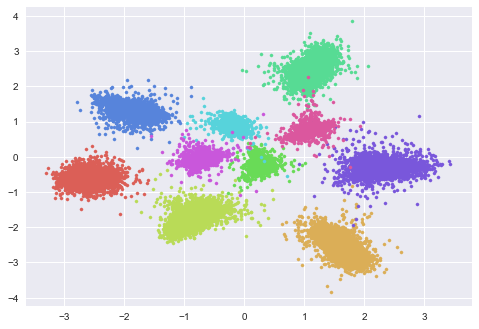

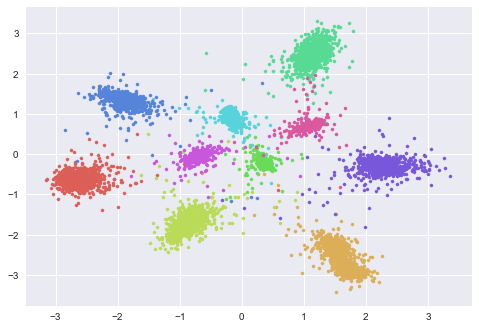

[epoch 41] lr 0.004457
[epoch 41][iter 51] loss: 0.188812
[epoch 41][iter 190] loss: 0.198363
[epoch 41][iter 318] loss: 0.230389
[epoch 41][iter 461] loss: 0.193794
[epoch 41][iter 600] loss: 0.222378
[epoch 41][test] loss: 0.011154
[epoch 42] lr 0.004368
[epoch 42][iter 155] loss: 0.183202
[epoch 42][iter 321] loss: 0.213629
[epoch 42][iter 460] loss: 0.210759
[epoch 42][test] loss: 0.011301
[epoch 43] lr 0.004281
[epoch 43][iter 11] loss: 0.229088
[epoch 43][iter 167] loss: 0.169752
[epoch 43][iter 294] loss: 0.236632
[epoch 43][iter 446] loss: 0.197522
[epoch 43][test] loss: 0.008026
[epoch 44] lr 0.004195
[epoch 44][iter 25] loss: 0.184802
[epoch 44][iter 190] loss: 0.187300
[epoch 44][iter 327] loss: 0.220911
[epoch 44][iter 481] loss: 0.208928
[epoch 44][test] loss: 0.009042
[epoch 45] lr 0.004111
[epoch 45][iter 22] loss: 0.194828
[epoch 45][iter 199] loss: 0.214176
[epoch 45][iter 363] loss: 0.190310
[epoch 45][iter 539] loss: 0.217789
[epoch 45][test] loss: 0.009535
[epoch 46

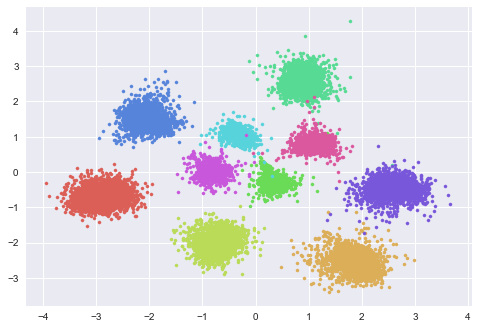

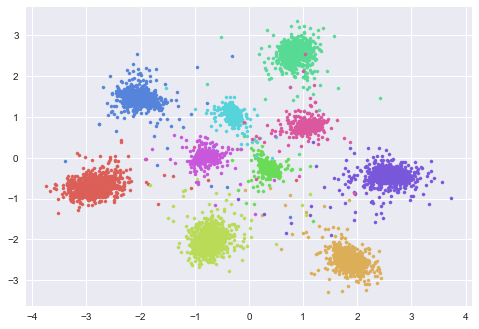

[epoch 51] lr 0.003642
[epoch 51][iter 168] loss: 0.214891
[epoch 51][iter 365] loss: 0.223699
[epoch 51][test] loss: 0.008625
[epoch 52] lr 0.003569
[epoch 52][iter 3] loss: 0.219519
[epoch 52][iter 228] loss: 0.173068
[epoch 52][iter 481] loss: 0.198278
[epoch 52][test] loss: 0.010152
[epoch 53] lr 0.003497
[epoch 53][iter 87] loss: 0.240744
[epoch 53][iter 332] loss: 0.153202
[epoch 53][iter 556] loss: 0.199325
[epoch 53][test] loss: 0.012854
[epoch 54] lr 0.003428
[epoch 54][iter 187] loss: 0.204290
[epoch 54][iter 408] loss: 0.213855
[epoch 54][test] loss: 0.008889
[epoch 55] lr 0.003359
[epoch 55][iter 23] loss: 0.222478
[epoch 55][iter 227] loss: 0.218031
[epoch 55][iter 488] loss: 0.212743
[epoch 55][test] loss: 0.006719
[epoch 56] lr 0.003292
[epoch 56][iter 115] loss: 0.181957
[epoch 56][iter 347] loss: 0.176002
[epoch 56][test] loss: 0.013643
[epoch 57] lr 0.003226
[epoch 57][iter 35] loss: 0.193441
[epoch 57][iter 269] loss: 0.214471
[epoch 57][iter 537] loss: 0.185268
[epo

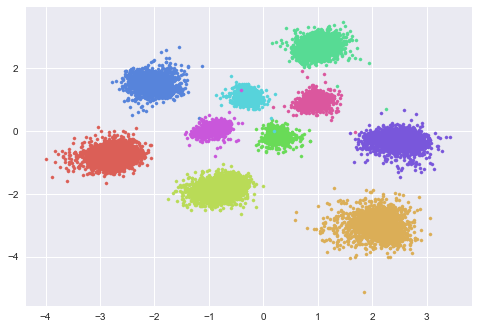

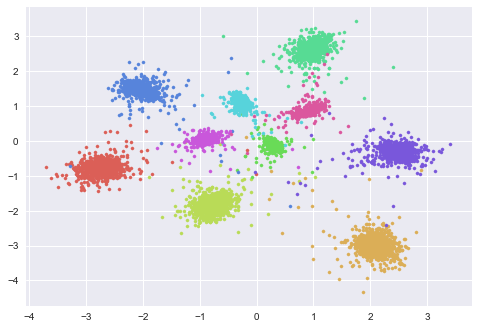

[epoch 61] lr 0.002976
[epoch 61][iter 289] loss: 0.188091
[epoch 61][test] loss: 0.005261
[epoch 62] lr 0.002916
[epoch 62][iter 91] loss: 0.210373
[epoch 62][iter 445] loss: 0.169723
[epoch 62][test] loss: 0.013324
[epoch 63] lr 0.002858
[epoch 63][iter 210] loss: 0.217588
[epoch 63][iter 541] loss: 0.191605
[epoch 63][test] loss: 0.012232
[epoch 64] lr 0.002801
[epoch 64][iter 260] loss: 0.204529
[epoch 64][iter 577] loss: 0.177012
[epoch 64][test] loss: 0.013460
[epoch 65] lr 0.002745
[epoch 65][iter 371] loss: 0.202647
[epoch 65][test] loss: 0.010698
[epoch 66] lr 0.002690
[epoch 66][iter 151] loss: 0.190143
[epoch 66][iter 471] loss: 0.242621
[epoch 66][test] loss: 0.010013
[epoch 67] lr 0.002636
[epoch 67][iter 186] loss: 0.183099
[epoch 67][iter 534] loss: 0.172539
[epoch 67][test] loss: 0.012613
[epoch 68] lr 0.002583
[epoch 68][iter 428] loss: 0.240184
[epoch 68][test] loss: 0.010921
[epoch 69] lr 0.002531
[epoch 69][iter 233] loss: 0.173438
[epoch 69][test] loss: 0.016744
[e

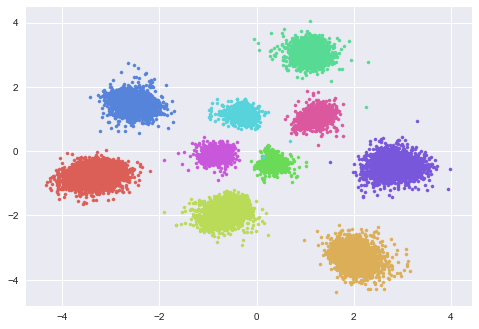

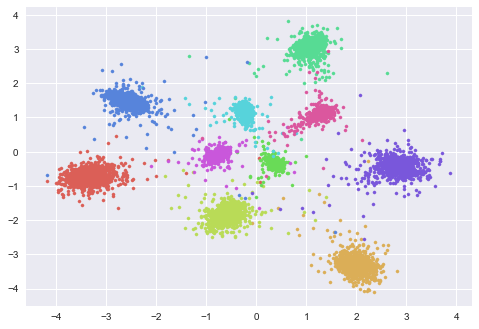

[epoch 71] lr 0.002431
[epoch 71][iter 233] loss: 0.215082
[epoch 71][test] loss: 0.010533
[epoch 72] lr 0.002383
[epoch 72][iter 312] loss: 0.194139
[epoch 72][test] loss: 0.012473
[epoch 73] lr 0.002335
[epoch 73][iter 297] loss: 0.188329
[epoch 73][test] loss: 0.012971
[epoch 74] lr 0.002288
[epoch 74][iter 198] loss: 0.208132
[epoch 74][test] loss: 0.009595
[epoch 75] lr 0.002242
[epoch 75][iter 456] loss: 0.169047
[epoch 75][test] loss: 0.016602
[epoch 76] lr 0.002198
[epoch 76][iter 575] loss: 0.186632
[epoch 76][test] loss: 0.009353
[epoch 77] lr 0.002154
[epoch 77][iter 563] loss: 0.214949
[epoch 77][test] loss: 0.011594
[epoch 78] lr 0.002111
[epoch 78][test] loss: 0.011414
[epoch 79] lr 0.002068
[epoch 79][iter 243] loss: 0.200414
[epoch 79][test] loss: 0.012424
[epoch 80] lr 0.002027
[epoch 80][test] loss: 0.016948


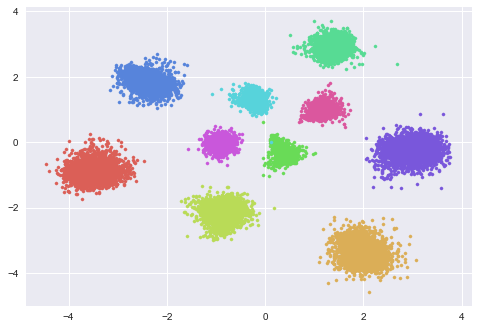

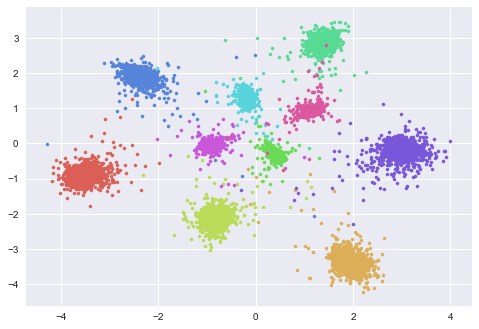

[epoch 81] lr 0.001986
[epoch 81][iter 90] loss: 0.186459
[epoch 81][test] loss: 0.015785
[epoch 82] lr 0.001947
[epoch 82][test] loss: 0.008490
[epoch 83] lr 0.001908
[epoch 83][iter 417] loss: 0.172599
[epoch 83][test] loss: 0.011325
[epoch 84] lr 0.001870
[epoch 84][test] loss: 0.012558
[epoch 85] lr 0.001832
[epoch 85][iter 373] loss: 0.189138
[epoch 85][test] loss: 0.016863
[epoch 86] lr 0.001796
[epoch 86][test] loss: 0.011919
[epoch 87] lr 0.001760
[epoch 87][test] loss: 0.013155
[epoch 88] lr 0.001725
[epoch 88][iter 384] loss: 0.216266
[epoch 88][test] loss: 0.012289
[epoch 89] lr 0.001690
[epoch 89][test] loss: 0.018737
[epoch 90] lr 0.001656
[epoch 90][test] loss: 0.009548


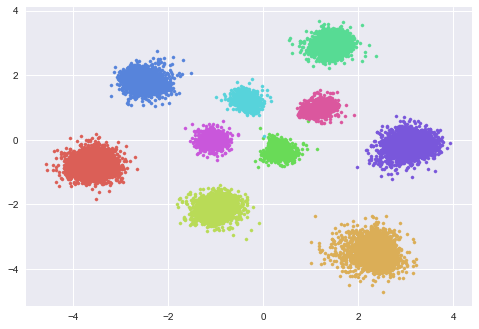

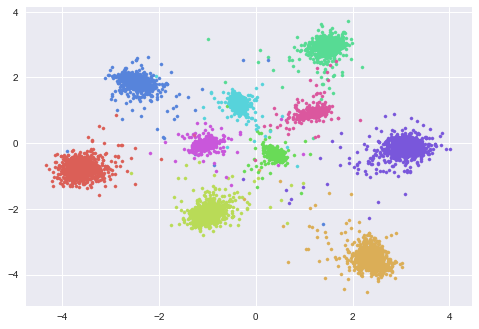

[epoch 91] lr 0.001623
[epoch 91][test] loss: 0.016710
[epoch 92] lr 0.001591
[epoch 92][iter 159] loss: 0.152966
[epoch 92][test] loss: 0.012246
[epoch 93] lr 0.001559
[epoch 93][test] loss: 0.017657
[epoch 94] lr 0.001528
[epoch 94][test] loss: 0.011202
[epoch 95] lr 0.001497
[epoch 95][test] loss: 0.013663
[epoch 96] lr 0.001467
[epoch 96][test] loss: 0.012009
[epoch 97] lr 0.001438
[epoch 97][iter 291] loss: 0.223314
[epoch 97][test] loss: 0.012654
[epoch 98] lr 0.001409
[epoch 98][test] loss: 0.011553
[epoch 99] lr 0.001381
[epoch 99][test] loss: 0.010972
[epoch 100] lr 0.001353
[epoch 100][test] loss: 0.012215


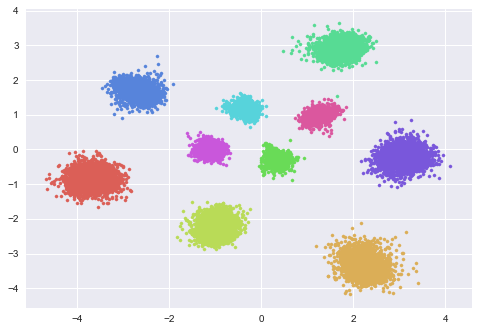

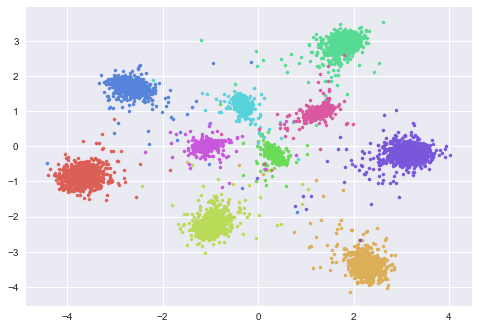

In [6]:
### Train part

class LossRecorder(object):

    def __init__(self, moving_len=100):
        self.moving_len = moving_len
        self.cur_loss = 0
        self.counter = 0
        self.losses = []

    def push(self, loss):
        self.cur_loss = self.cur_loss + loss
        self.counter += 1
        rv = None
        if self.counter == self.moving_len:
            self.losses.append(self.cur_loss / self.moving_len)
            self.cur_loss = 0
            self.counter = 0
            rv = self.losses[-1]
        return rv

    @property
    def loss(self):
        return np.array(self.losses)


def calc_label_index(label):
    label = label.asnumpy()
    label_idx = [[] for _ in range(10)]
    for i, digit in enumerate(label):
        label_idx[int(digit)].append(i)
    neg_idx = [[] for _ in range(10)]
    for i in range(10):
        for j in range(10):
            if i != j:
                neg_idx[i] += label_idx[j]
    label_idx = [np.array(_) for _ in label_idx]
    neg_idx = [np.array(_) for _ in neg_idx]

    return label_idx, neg_idx


def semihard_sample(diss, label, margin):
    label_idx, neg_idx = calc_label_index(label)
    diss = diss.asnumpy()
    anchor_idx = []
    positive_idx = []
    negative_idx = []
    for k in range(10):
        n = len(label_idx[k])
        for i in range(n):
            for j in range(n):
                if i != j:
                    ii = label_idx[k][i]
                    jj = label_idx[k][j]
                    dmin, dmax = diss[ii, jj], diss[ii, jj] + margin
                    neg_dis = diss[ii][neg_idx[k]]
                    ind = np.where(neg_dis < dmax)[0]
                    ind = neg_idx[k][ind]
                    if len(ind) != 0:
                        anchor_idx.append(ii)
                        positive_idx.append(jj)
                        negative_idx.append(np.random.choice(ind))
    return nd.array(anchor_idx, ctx=ctx), nd.array(positive_idx, ctx=ctx), nd.array(negative_idx, ctx=ctx)


def random_sample(embedding, label):
    label_idx, neg_idx = calc_label_index(label)
    anchor_idx = []
    positive_idx = []
    negative_idx = []
    for k in range(10):
        n = len(label_idx[k])
        for i in range(n):
            for j in range(n):
                if i != j:
                    anchor_idx.append(label_idx[k][i])
                    positive_idx.append(label_idx[k][j])
                    negative_idx.append(np.random.choice(neg_idx[k]))
    return nd.array(anchor_idx, ctx=ctx), nd.array(positive_idx, ctx=ctx), nd.array(negative_idx, ctx=ctx)


train_recorder = LossRecorder(moving_len=100)
test_recorder = LossRecorder(moving_len=1)

for epoch in range(epoches):
    print('[epoch %d] lr %f' % (epoch + 1, trainer.learning_rate))
    for i, (data, label) in enumerate(train_loader):
        data = data[0].as_in_context(ctx)
        label = label[0].as_in_context(ctx)
        valid = True
        with autograd.record():
            embedding = net(data)
            with autograd.pause():
                x = embedding
                n = embedding.shape[0]
                x2 = nd.sum(nd.square(x), axis=1)
                xi = x2.reshape((n, 1)).tile(reps=(1, n))
                xj = x2.reshape((1, n)).tile(reps=(n, 1))
                diss = xi + xj - 2 * nd.dot(x, x.T)
                anchor_idx, positive_idx, negative_idx = semihard_sample(diss, label, margin)
            if anchor_idx.size > 0:
                anchor = embedding.take(anchor_idx)
                positive = embedding.take(positive_idx)
                negative = embedding.take(negative_idx)
                loss = criterion(anchor, positive, negative)
            else:
                valid = False
                loss = None
        if valid:
            loss.backward()
            trainer.step(loss.shape[0])
            rv = train_recorder.push(loss.mean().asscalar())
            if rv is not None:
                print('[epoch %d][iter %d] loss: %f' %  (epoch + 1, i + 1, rv))
    test_loss = 0
    test_counter = 0
    for i, (data, label) in enumerate(test_loader):
        data = data[0].as_in_context(ctx)
        label = label[0].as_in_context(ctx)
        embedding = net(data)
        anchor_idx, positive_idx, negative_idx = random_sample(embedding, label)
        anchor = embedding.take(anchor_idx)
        positive = embedding.take(positive_idx)
        negative = embedding.take(negative_idx)
        loss = criterion(anchor, positive, negative)
        test_loss += loss.mean().asscalar()
        test_counter += 1
    test_loss /= test_counter
    test_recorder.push(test_loss)
    print('[epoch %d][test] loss: %f' % (epoch + 1, test_loss))
    trainer.set_learning_rate(trainer.learning_rate * 0.98)
    net.save_params('./tmp/net-%04d.params'%(epoch + 1))
    if epoch % 10 == 9:
        plot_mnist_test(epoch+1, True)
        plot_mnist_test(epoch+1, False)